<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Risk Parity & Budgeting with Python

### Risk Allocation & Risk Parity

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

http://tpq.io | [@dyjh](http://twitter.com/dyjh) | [team@tpq.io](mailto:team@tpq.io) 

## Imports and Data

In [1]:
from pylab import plt
from mvp_portfolio import *
plt.style.use('seaborn')
np.set_printoptions(suppress=True)
%config InlineBackend.figure_format = 'svg'

In [2]:
url = 'universe.csv'

In [3]:
data = pd.read_csv(url, index_col=0, parse_dates=True).dropna()
data = data.loc['2019-1-1':]

In [4]:
rets = np.log(data / data.shift(1))

In [5]:
noa = len(data.columns)
noa

4

## Equally Weighted Portfolio

In [6]:
phi = np.array(noa * [1 / noa])
phi

array([0.25, 0.25, 0.25, 0.25])

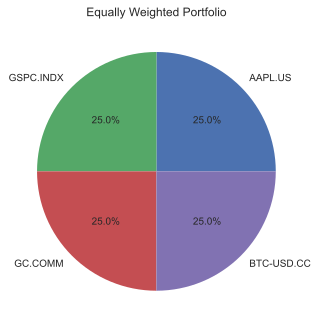

In [7]:
plt.pie(phi, labels=data.columns, autopct='%1.1f%%')
plt.title('Equally Weighted Portfolio');

In [8]:
cov = rets.cov() * 252

In [9]:
cov

,AAPL.US,GSPC.INDX,GC.COMM,BTC-USD.CC
AAPL.US,0.120173,0.065097,0.003593,0.067450
GSPC.INDX,0.065097,0.053587,0.003422,0.059182
GC.COMM,0.003593,0.003422,0.026494,0.017196
BTC-USD.CC,0.067450,0.059182,0.017196,0.551247


In [10]:
vol = portfolio_volatility(phi, rets)
vol

0.27195820100279067

In [11]:
vol / noa  # "average" risk contribution

0.06798955025069767

In [12]:
np.dot(cov, phi)

array([0.06407829, 0.04532193, 0.01267623, 0.1737686 ])

In [13]:
mvols = np.dot(cov, phi) / vol  # marginal volatilities
mvols

array([0.23561816, 0.16665037, 0.04661094, 0.63895333])

In [14]:
rc = mvols * phi  # risk contributions (%-points)
rc

array([0.05890454, 0.04166259, 0.01165274, 0.15973833])

In [15]:
rc.sum()

0.27195820100279056

In [16]:
rrc = rc / rc.sum()  # relative risk contributions (%)
rrc

array([0.2165941 , 0.15319484, 0.04284752, 0.58736354])

In [17]:
rrc.sum()

1.0

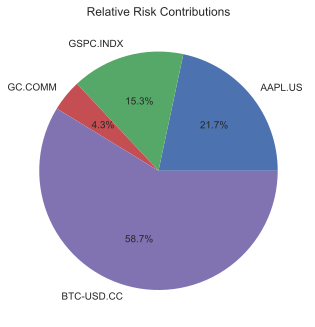

In [18]:
plt.pie(rrc, labels=data.columns, autopct='%1.1f%%')
plt.title('Relative Risk Contributions');

In [19]:
sum(rc / rc.sum())  # checking for sum of relative risk contributions

1.0

## Risk Parity Portfolios

In [20]:
from scipy.optimize import minimize

In [21]:
def rel_risk_contributions(weights, rets=rets):
    vol = portfolio_volatility(weights, rets)
    cov = rets.cov()
    mvols = np.dot(cov, weights) / vol
    rc = mvols * weights
    rrc = rc / rc.sum()
    return rrc

In [22]:
rrc = rel_risk_contributions(phi)
rrc

array([0.2165941 , 0.15319484, 0.04284752, 0.58736354])

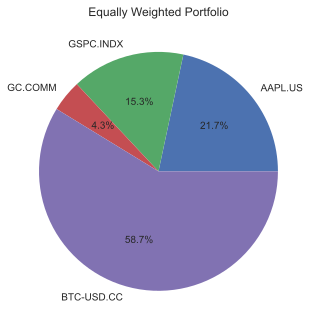

In [23]:
plt.pie(rrc, labels=data.columns, autopct='%1.1f%%')
plt.title('Equally Weighted Portfolio');

In [24]:
def mse_risk_contributions(weights, target, rets=rets):
    rc = rel_risk_contributions(weights, rets)
    mse = ((rc - target) ** 2).mean()
    return mse * 100

In [25]:
mse_risk_contributions(phi, phi)

4.18033752705142

In [26]:
bnds = noa * [(0, 1),]

In [27]:
cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}

In [28]:
target = noa * [1 / noa,]  # risk parity as target
target = [0.2, 0.2, 0.2, 0.4]  # example risk budget as target
target

[0.2, 0.2, 0.2, 0.4]

In [29]:
opt = minimize(lambda w: mse_risk_contributions(w, target=target),
               phi, bounds=bnds, constraints=cons)

In [30]:
opt

     fun: 7.652184480898886e-10
     jac: array([-0.0001045 ,  0.00019882, -0.00012217,  0.00021254])
 message: 'Optimization terminated successfully.'
    nfev: 67
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([0.16474233, 0.22970954, 0.46721675, 0.13833138])

In [31]:
phi_ = opt['x']

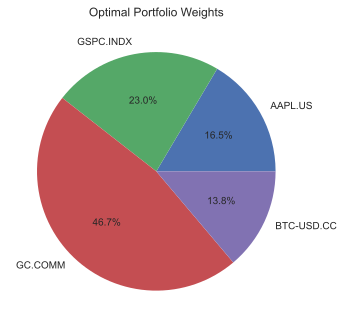

In [32]:
plt.pie(phi_, labels=data.columns, autopct='%1.1f%%')
plt.title('Optimal Portfolio Weights');

In [33]:
rrc = rel_risk_contributions(opt['x'])
rrc

array([0.1999981 , 0.20000399, 0.19999685, 0.40000106])

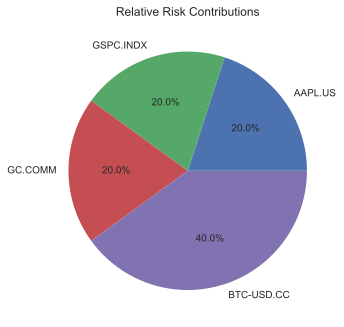

In [34]:
plt.pie(rrc, labels=data.columns, autopct='%1.1f%%')
plt.title('Relative Risk Contributions');

In [35]:
portfolio_volatility(opt['x'], rets)

0.1941484265023798

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="30%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>